 > This is a terrible attempt to replicate Ian's post (you can [find it here](http://www.cs.princeton.edu/~chazelle/courses/BIB/pagerank.htm)) that I made for my own understanding of the Google PageRank algorithm.

# The Google Pagerank Algorithm and How It Works  

Ian Rogers  
IPR Computing Ltd.  
ian@iprcom.com

## Introduction  
Page Rank is a topic much discussed by Search Engine Optimisation (SEO) experts. At the heart of PageRank is a mathematical formula that seems scary to look at but is actually fairly simple to understand.

Despite this many people seem to get it wrong! In particular “Chris Ridings of www.searchenginesystems.net” has written a paper entitled “PageRank Explained: Everything you’ve always wanted to know about PageRank”, pointed to by many people, that contains a [fundamental mistake](http://www.iprcom.com/papers/pagerank/altered_equation.html) early on in the explanation! Unfortunately this means some of the recommendations in the paper are not quite accurate.

By showing code to correctly calculate real PageRank I hope to achieve several things in this response:  


 1. Clearly explain how PageRank is calculated.
 2. Go through every example in Chris’ paper, and add some more of my own, showing the correct PageRank for each diagram. By showing the code used to calculate each diagram I’ve opened myself up to peer review - mostly in an effort to make sure the examples are correct, but also because the code can help explain the PageRank calculations.  
 3. Describe some principles and observations on website design based on these correctly calculated examples.
 4. Any good web designer should take the time to fully understand how PageRank really works - if you don’t then your site’s layout could be seriously hurting your Google listings!

[Note: I have nothing in particular against Chris. If I find any other papers on the subject I’ll try to comment evenly]

## How is PageRank Used?  
PageRank is one of the methods Google uses to determine a page’s relevance or importance. It is only one part of the story when it comes to the Google listing, but the other aspects are discussed elsewhere (and are ever changing) and PageRank is interesting enough to deserve a paper of its own.  

PageRank is also displayed on the toolbar of your browser if you’ve installed the Google toolbar ([http://toolbar.google.com/](http://toolbar.google.com/)). But the Toolbar PageRank only goes from 0 – 10 and seems to be something like a logarithmic scale:  

| Toolbar PageRank (log base 10) | Real PageRank    |
| ------------------------------ |:----------------:|
| 0                              | 0 - 10           |
| 1                              | 100 - 1,000      |
| 2                              | 1,000 - 10,000   |
| 3                              | 10,000 - 100,000 |
| 4                              | and so on...     |  

We can’t know the exact details of the scale because, as we’ll see later, the maximum PR of all pages on the web changes every month when Google does its re-indexing! If we presume the scale is logarithmic (although there is only anecdotal evidence for this at the time of writing) then Google could simply give the highest actual PR page a toolbar PR of 10 and scale the rest appropriately.

Also the toolbar sometimes guesses! The toolbar often shows me a Toolbar PR for pages I’ve only just uploaded and cannot possibly be in the index yet!

What seems to be happening is that the toolbar looks at the URL of the page the browser is displaying and strips off everything down the last “/” (i.e. it goes to the “parent” page in URL terms). If Google has a Toolbar PR for that parent then it subtracts 1 and shows that as the Toolbar PR for this page. If there’s no PR for the parent it goes to the parent’s parent’s page, but subtracting 2, and so on all the way up to the root of your site.  If it can’t find a Toolbar PR to display in this way, that is if it doesn’t find a page with a real calculated PR, then the bar is greyed out.

Note that if the Toolbar is guessing in this way, the Actual PR of the page is 0 - though its PR will be calculated shortly after the Google spider first sees it.

PageRank says nothing about the content or size of a page, the language it’s written in, or the text used in the anchor of a link!

## Definitions  
I’ve started to use some technical terms and shorthand in this paper. Now’s as good a time as any to define all the terms I’ll use:  

 - $PR$: Shorthand for PageRank: the actual, real, page rank for each page as calculated by Google. As we’ll see later this can range from 0.15 to billions.  
 - Toolbar $PR$: The PageRank displayed in the Google toolbar in your browser. This ranges from 0 to 10.
 - Backlink: If page A links out to page B, then page B is said to have a “backlink” from page A.  
 
## So what is PageRank?  
In short PageRank is a “vote”, by all the other pages on the Web, about how important a page is. A link to a page counts as a vote of support. If there’s no link there’s no support (but it’s an abstention from voting rather than a vote against the page).

Quoting from the original Google paper, PageRank is defined like this:

 > We assume page $A$ has pages $T_1 ...T_n$ which point to it (i.e., are citations). The parameter d is a damping factor which can be set between $0$ and $1$. We usually set d to $0.85$. There are more details about $d$ in the next section. Also $C(A)$ is defined as the number of links going out of page $A$. The PageRank of a page $A$ is given as follows:

 > $PR(A) = (1-d) + d (PR(T_1)/C(T_1) + ... + PR(T_n)/C(T_n))$

 > Note that the PageRanks form a probability distribution over web pages, so the sum of all web pages' PageRanks will be one.

 > PageRank or $PR(A)$ can be calculated using a simple iterative algorithm, and corresponds to the principal eigenvector of the normalized link matrix of the web.

but that’s not too helpful so let’s break it down into sections.  

 1. $PR(T_n)$ - Each page has a notion of its own self-importance. That’s “$PR(T_1)$” for the first page in the web all the way up to “$PR(T_n)$” for the last page
 2. $C(T_n)$ - Each page spreads its vote out evenly amongst all of it’s outgoing links. The count, or number, of outgoing links for page $1$ is “$C(T1)$”, “$C(Tn)$” for page $n$, and so on for all pages.  
 3. $PR(T_n)/C(T_n)$ - so if our page (page $A$) has a backlink from page “$n$” the share of the vote page $A$ will get is “$PR(T_n)/C(T_n)$”  
 4. $d(...$ - All these fractions of votes are added together but, to stop the other pages having too much influence, this total vote is “damped down” by multiplying it by $0.85$ (the factor “$d$”)
 5. $(1 - d)$ - The $(1 – d)$ bit at the beginning is a bit of probability math magic so the “sum of all web pages' PageRanks will be one”: it adds in the bit lost by the d(.... It also means that if a page has no links to it (no backlinks) even then it will still get a small PR of $0.15$ (i.e. $1 – 0.85$). (Aside: the Google paper says “the sum of all pages” but they mean the “the normalised sum” – otherwise known as “the average” to you and me. 

In [19]:
from graphviz import Source

class PageRank:
    def __init__(self, pages, d=0.85, initial_guess=1.0):
        """
        :param pages: A graph of pages represented as linked lists
        :param d: The dampening factor
        :param initial_guess: The initial value for page rank
        """
        self.d = d
        self.pages = pages
        self.inverse_pages = {}
        self.outlinks = {}
        self.inlinks = {}
        self.pr = {}
        self.all_pages = set()

        for page in pages:
            self.outlinks[page] = len(pages[page])
            self.all_pages.add(page)
            for out in pages[page]:
                self.all_pages.add(out)
                self.inlinks[out] = self.inlinks.get(out, 0) + 1

                if out not in self.inverse_pages:
                    self.inverse_pages[out] = []
                self.inverse_pages[out].append(page)

        for page in self.all_pages:
            self.pr[page] = initial_guess

    def calculate(self, iters, report=False, report_every=1, rep_function=None):
        """
        Calculates the page rank of the given page graph
        :param iters: Number of iterations
        :param report: Wether you want the code to report every iteration to the console
        :return:
        """
        for i in range(1, iters+1):
            pr_copy = dict(self.pr)
            for page in self.pr:
                self.pr[page] = 1 - self.d
                mid = 0
                if page in self.inverse_pages:
                    for page_linked in self.inverse_pages[page]:
                        mid += self.pr[page_linked] / self.outlinks[page_linked]
                self.pr[page] += mid * self.d
            if report:
                if i % report_every == 0:
                    if rep_function is not None:
                        rep_function(i, self.pr)
                    else:
                        print("Iteration %d" % i)
                        print(self.pr)

    def get_avg(self):
        d = 0
        for p in self.pr:
            d += self.pr[p]
        return d / len(self.pr)

    def get_digraph(self, show_pr=False):
        string_source = "digraph G {\n\tnode [shape=record];\n\trankdir=LR;\n\t"
        if show_pr:
            for page in self.pages:
                string_source += page.replace(" ","_")+'[label=<' + page +'<BR />' + \
                '<FONT POINT-SIZE="9">PR %.4f</FONT>>];\n' % self.pr[page]
            
        for page in self.pages:
            for out in self.pages[page]:
                string_source += "%s->%s\n" % (page.replace(" ","_"), out.replace(" ","_"))
        string_source += "}"
        return Source(string_source)


# A small reporting function
def report(iteration, page_rank):
    print("Iteration %d" % iteration)
    for page in page_rank:
        print("\t%s: %0.6f" % (page, page_rank[page]))

 
## How is PageRank Calculated?  
This is where it gets tricky. The PR of each page depends on the PR of the pages pointing to it. But we won’t know what PR those pages have until the pages pointing to them have their PR calculated and so on… And when you consider that page links can form circles it seems impossible to do this calculation!

But actually it’s not that bad. Remember this bit of the Google paper:

PageRank or $PR(A)$ can be calculated using a simple iterative algorithm, and corresponds to the principal eigenvector of the normalized link matrix of the web.

What that means to us is that we can just go ahead and calculate a page’s PR without knowing the final value of the PR of the other pages. That seems strange but, basically, each time we run the calculation we’re getting a closer estimate of the final value. So all we need to do is remember the each value we calculate and repeat the calculations lots of times until the numbers stop changing much.

Lets take the simplest example network: two pages, each pointing to the other:

In [20]:
pages = {
    "A": ["B"],
    "B": ["A"]
}

Each page has one outgoing link (the outgoing count is $1$, i.e. $C(A) = 1$ and $C(B) = 1$).

### Guess 1

We don’t know what their PR should be to begin with, so let’s take a guess at $1.0$ and do some calculations:

$$d = 0.85$$

$$PR(A) = (1 – d) + d(PR(B)/1)$$

$$PR(B) = (1 – d) + d(PR(A)/1)$$

i.e.

$$PR(A) = 0.15 + 0.85 * 1 = 1$$  

$$PR(B) = 0.15 + 0.85 * 1 = 1$$

Hmm, the numbers aren’t changing at all! So it looks like we started out with a lucky guess!!!

Iteration 1
	A: 1.000000
	B: 1.000000


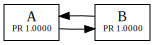

In [21]:
pr = PageRank(pages, initial_guess=1)
pr.calculate(1, report=True, rep_function=report)
pr.get_digraph(show_pr=True)

### Guess 2

No, that’s too easy, maybe I got it wrong (and it wouldn’t be the first time). Ok, let’s start the guess at 0 instead and re-calculate:

$$PR(A) = 0.15 + 0.85 * 0 = 0.15$$  

$$PR(B) = 0.15 + 0.85 * 0.15 = 0.2775$$

NB. we’ve already calculated a “next best guess” at $PR(A)$ so we use it here

And again:

$$PR(A) = 0.15 + 0.85 * 0.2775 = 0.385875$$

$$PR(B) = 0.15 + 0.85 * 0.385875 = 0.47799375$$

And again

$$PR(A) = 0.15 + 0.85 * 0.47799375 = 0.5562946875$$

$$PR(B) = 0.15 + 0.85 * 0.5562946875 = 0.622850484375$$

and so on. The numbers just keep going up. But will the numbers stop increasing when they get to $1.0$? What if a calculation over-shoots and goes above $1.0$?

Iteration 1
	A: 0.150000
	B: 0.277500
Iteration 2
	A: 0.385875
	B: 0.477994
Iteration 3
	A: 0.556295
	B: 0.622850


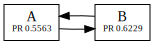

In [22]:
pr = PageRank(pages, initial_guess=0)
pr.calculate(3, report=True, rep_function=report)
pr.get_digraph(show_pr=True)

### Guess 3

Well let’s see. Let’s start the guess at 40 each and do a few cycles:

$$PR(A) = 40$$
$$PR(B) = 40$$

First calculation

$$PR(A) = 0.15 + 0.85 * 40 = 34.25$$

$$PR(B) = 0.15 + 0.85 * 0.385875 = 29.1775$$

And again

$$PR(A) = 0.15 + 0.85 * 29.1775 = 24.950875$$

$$PR(B) = 0.15 + 0.85 * 24.950875 = 21.35824375$$

Yup, those numbers are heading down alright! It sure looks the numbers will get to $1.0$ and stop

Iteration 1
	A: 34.150000
	B: 29.177500
Iteration 2
	A: 24.950875
	B: 21.358244


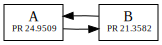

In [23]:
pr = PageRank(pages, initial_guess=40)
pr.calculate(2, report=True, rep_function=report)
pr.get_digraph(show_pr=True)

Here’s the code used to calculate this example starting the guess at $0$: Show the code | Run the program

 - **Principle**: it doesn’t matter where you start your guess, once the PageRank calculations have settled down, the “normalized probability distribution” (the average PageRank for all pages) will be $1.0$

## Getting the answer quicker
How many times do we need to repeat the calculation for big networks? That’s a difficult question; for a network as large as the World Wide Web it can be many millions of iterations! The “damping factor” is quite subtle. If it’s too high then it takes ages for the numbers to settle, if it’s too low then you get repeated over-shoot, both above and below the average - the numbers just swing about the average like a pendulum and never settle down.  

Also choosing the order of calculations can help. The answer will always come out the same no matter which order you choose, but some orders will get you there quicker than others.  

I’m sure there’s been several Master’s Thesis on how to make this calculation as efficient as possible, but, in the examples below, I’ve used very simple code for clarity and roughly 20 to 40 iterations were needed!

### Example 1

In [24]:
pages = {
    "A": ["B", "C"],
    "B": ["C"],
    "C": ["A"],
    "D": ["C"],
}

I’m not going to repeat the calculations here, but you can see them by running the program (yes, if you click the link the program really is re-run to do the calculations for you)

So the correct PR for the example is:

Iteration 10
	A: 1.473742
	D: 0.150000
	C: 1.561783
	B: 0.776340
Iteration 20
	A: 1.489001
	D: 0.150000
	C: 1.575603
	B: 0.782825


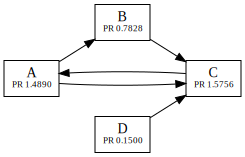

In [25]:
pr = PageRank(pages, initial_guess=1)
pr.calculate(20, report=True, report_every=10, rep_function=report)
pr.get_digraph(show_pr=True)

You can see it took about $20$ iterations before the network began to settle on these values!

Look at Page D though - it has a PR of $0.15$ even though no-one is voting for it (i.e. it has no incoming links)! Is this right?

The first part, or "term" to be techinal, of the PR equation is doing this:

$$PR(A) = (1-d) + d (PR(T_1)/C(T_1) + ... + PR(T_n)/C(T_n))$$

So, for Page D, no backlinks means the equation looks like this:

$$PR(A) = (1-d) + d * (0) = 0.15$$

no matter what else is going on or how many times you do it.

 - **Observation**: every page has at least a PR of 0.15 to share out. But this may only be in theory - there are rumours that Google undergoes a post-spidering phase whereby any pages that have no incoming links at all are completely deleted from the index...

### Example 2

In [26]:
pages = {
    "Home": ["About", "Product", "Links"],
    "About": ["Home"],
    "Product": ["Home"],
    "Links": ["Home","External Site A", "External Site B", "External Site C", "External Site D"]
}

Iteration 20
	Links: 0.409431
	About: 0.409431
	Home: 0.915636
	Product: 0.409430
	External Site B: 0.219603
	External Site A: 0.219603
	External Site D: 0.219603
	External Site C: 0.219603
Average PR: 0.378


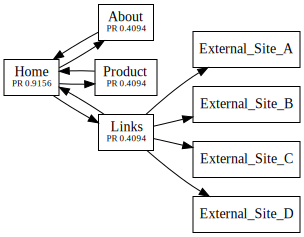

In [27]:
pr = PageRank(pages, initial_guess=1)
pr.calculate(20, report=True, report_every=20, rep_function=report)
print("Average PR: %.3f" % pr.get_avg())
pr.get_digraph(show_pr=True)

As you’d expect, the home page has the most PR – after all, it has the most incoming links! But what’s happened to the average? It’s only 0.378!!! That doesn’t tie up with what I said earlier so something is wrong somewhere!

Well no, everything is fine. But take a look at the “external site” pages – what’s happening to their PageRank? They’re not passing it on, they’re not voting for anyone, they’re wasting their PR like so much pregnant chad!!! (NB, a more accurate description of this issue can be found in this [thread](http://www.marketpositiontalk.com/forums/Index.cfm?CFApp=11&Message_ID=37917))

### Example 3  
Let’s link those external sites back into our home page just so we can see what happens to the average…

Iteration 20
	Links: 1.101035
	About: 1.101035
	Home: 3.355559
	Product: 1.100742
	External Site B: 0.337176
	External Site A: 0.337176
	External Site D: 0.337176
	External Site C: 0.337176
Average PR: 1.001


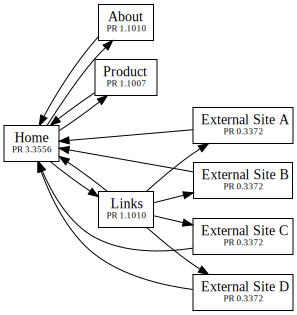

In [28]:
pages = {
    "Home": ["About", "Product", "Links"],
    "About": ["Home"],
    "Product": ["Home"],
    "Links": ["Home","External Site A", "External Site B", "External Site C", "External Site D"],
    "External Site A": ["Home"],
    "External Site B": ["Home"],
    "External Site C": ["Home"],
    "External Site D": ["Home"]
}

pr = PageRank(pages, initial_guess=1)
pr.calculate(20, report=True, report_every=20, rep_function=report)
print("Average PR: %.3f" % pr.get_avg())
pr.get_digraph(show_pr=True)

That’s better - it does work after all! And look at the PR of our home page! All those incoming links sure make a difference – we’ll talk more about that later.

### Example 4  
What happens to PR if we follow a suggestion about writing page reviews?

Iteration 20
	Review A: 0.229462
	Links: 0.841320
	Review C: 0.229458
	About: 0.841320
	Home: 2.439868
	Product: 0.841296
	External Site B: 0.229458
	External Site A: 0.229458
	External Site D: 0.229458
	Review D: 0.229458
	Review B: 0.229458
	External Site C: 0.229458
Average PR: 0.567


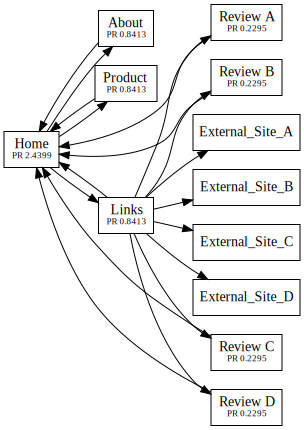

In [29]:
pages = {
    "Home": ["About", "Product", "Links"],
    "About": ["Home"],
    "Product": ["Home"],
    "Links": ["Home",
              "External Site A", "External Site B", 
              "External Site C", "External Site D",
              "Review A", "Review B", "Review C", "Review D"],
    "Review A": ["Home"],
    "Review B": ["Home"],
    "Review C": ["Home"],
    "Review D": ["Home"]
}

pr = PageRank(pages, initial_guess=1)
pr.calculate(20, report=True, report_every=20, rep_function=report)
print("Average PR: %.3f" % pr.get_avg())
pr.get_digraph(show_pr=True)

### Example 5  
A simple hierarchy  

Iteration 20
	About: 0.693152
	More: 0.693152
	Product: 0.693152
	Home: 1.917538
Average PR: 0.999


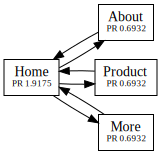

In [30]:
pages = {
    "Home": ["About", "Product", "More"],
    "About": ["Home"],
    "Product": ["Home"],
    "More": ["Home"]
}

pr = PageRank(pages, initial_guess=1)
pr.calculate(20, report=True, report_every=20, rep_function=report)
print("Average PR: %.3f" % pr.get_avg())
pr.get_digraph(show_pr=True)

Our home page has 2 and a half times as much PR as the child pages! Excellent!

 - **Observation**: a hierarchy concentrates votes and PR into one page

### Example 6  
Looping

Iteration 20
	About: 1.000000
	More: 1.000000
	Product: 1.000000
	Home: 1.000000
Average PR: 1.000


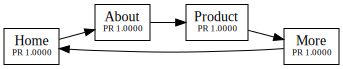

In [31]:
pages = {
    "Home": ["About"],
    "About": ["Product"],
    "Product": ["More"],
    "More": ["Home"]
}

pr = PageRank(pages, initial_guess=1)
pr.calculate(20, report=True, report_every=20, rep_function=report)
print("Average PR: %.3f" % pr.get_avg())
pr.get_digraph(show_pr=True)

This is what we’d expect. All the pages have the same number of incoming links, all pages are of equal importance to each other, all pages get the same PR of 1.0 (i.e. the “average” probability).

### Example 7  
Extensive Interlinking – or Fully Meshed

Iteration 20
	About: 1.000000
	More: 1.000000
	Product: 1.000000
	Home: 1.000000
Average PR: 1.000


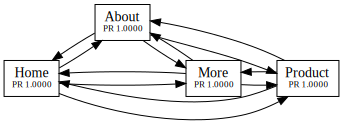

In [32]:
pages = {
    "Home": ["About","Product","More"],
    "About": ["Product","Home","More"],
    "Product": ["More","Home","About"],
    "More": ["Home","Product","About"]
}

pr = PageRank(pages, initial_guess=1)
pr.calculate(20, report=True, report_every=20, rep_function=report)
print("Average PR: %.3f" % pr.get_avg())
pr.get_digraph(show_pr=True)

Yes, the results are the same as the Looping example above and for the same reasons.

### Example 8 
Hierarchical – but with a link in and one out.

We’ll assume there’s an external site that has lots of pages and links with the result that one of the pages has the average PR of 1.0. We’ll also assume the webmaster really likes us – there’s just one link from that page and it’s pointing at our home page.

In [38]:
# Missing

In example 5 the home page only had a PR of 1.92 but now it is 3.31! Excellent! Not only has site A contributed 0.85 PR to us, but the raised PR in the “About”, “Product” and “More” pages has had a lovely “feedback” effect, pushing up the home page’s PR even further!

 - Priciple: a well structured site will amplify the effect of any contributed PR

### Example 9 
Looping – but with a link in and a link out

In [ ]:
# Missing

Well, the PR of our home page has gone up a little, but what’s happened to the “More” page?

The vote of the “Product” page has been split evenly between it and the external site. We now value the external Site B equally with our “More” page. The “More” page is getting only half the vote it had before – this is good for Site B but very bad for us!

### Example 10   
Fully meshed – but with one vote in and one vote out  

In [ ]:
# Missing

That’s much better. The “More” page is still getting less share of the vote than in example 7 of course, but now the “Product” page has kept three quarters of its vote within our site - unlike example 10 where it was giving away fully half of it’s vote to the external site!

Keeping just this small extra fraction of the vote within our site has had a very nice effect on the Home Page too – PR of 2.28 compared with just 1.66 in example 10.

 - **Observation**: increasing the internal links in your site can minimise the damage to your PR when you give away votes by linking to external sites. 
 - **Principle**: 
     - If a particular page is highly important – use a hierarchical structure with the important page at the “top”.
     - Where a group of pages may contain outward links – increase the number of internal links to retain as much PR as possible.
     - Where a group of pages do not contain outward links – the number of internal links in the site has no effect on the site’s average PR. You might as well use a link structure that gives the user the best navigational experience.

## Site Maps  
Site maps are useful in at least two ways:

 - If a user types in a bad URL most websites return a really unhelpful “404 – page not found” error page. This can be discouraging. Why not configure your server to return a page that shows an error has been made, but also gives the site map? This can help the user enormously  
 - Linking to a site map on each page increases the number of internal links in the site, spreading the PR out and protecting you against your vote “donations”
 

### Example 11  
Lets try to fix our site to artificially concentrate the PR into the home page.

That looks good, most of the links seem to be pointing up to page A so we should get a nice PR.

Try to guess what the PR of A will be before you scroll down or run the code.

Oh dear, that didn’t work at all well – it’s much worse than just an ordinary hierarchy! What’s going on is that pages C and D have such weak incoming links that they’re no help to page A at all!

 - **Principle**: trying to abuse the PR calculation is harder than you think.

### Example 12  
A common web layout for long documentation is to split the document into many pages with a “Previous” and “Next” link on each plus a link back to the home page. The home page then only needs to point to the first page of the document.

In this simple example, where there’s only one document, the first page of the document has a higher PR than the Home Page! This is because page B is getting all the vote from page A, but page A is only getting fractions of pages B, C and D.

 - **Principle**: in order to give users of your site a good experience, you may have to take a hit against your PR. There’s nothing you can do about this - and neither should you try to or worry about it! If your site is a pleasure to use lots of other webmasters will link to it and you’ll get back much more PR than you lost.  
 
Can you also see the trend between this and the previous example? As you add more internal links to a site it gets closer to the Fully Meshed example where every page gets the average PR for the mesh.

 - **Observation**: as you add more internal links in your site, the PR will be spread out more evenly between the pages.

### Example 13  
Getting high PR the wrong way and the right way.

Just as an experiment, let’s see if we can get 1,000 pages pointing to our home page, but only have one link leaving it…

Yup, those spam pages are pretty worthless but they sure add up!

 - **Observation**: it doesn’t matter how many pages you have in your site, your average PR will always be 1.0 at best. But a hierarchical layout can strongly concentrate votes, and therefore the PR, into the home page!  

This is a technique used by some disreputable sites (mostly adult content sites). But I can’t advise this - if Google’s robots decide you’re doing this there’s a good chance you’ll be banned from Google! Disaster!

On the other hand there are at least two right ways to do this:

## 1. Be a Mega-site

Mega-sites, like [http://news.bbc.co.uk](http://news.bbc.co.uk) have tens or hundreds of editors writing new content – i.e. new pages - all day long! Each one of those pages has rich, worthwile content of its own and a link back to its parent or the home page! That’s why the Home page Toolbar PR of these sites is 9/10 and the rest of us just get pushed lower and lower by comparison…

 - **Principle**: Content Is King! There really is no substitute for lots of good content…

## 2. Give away something useful

[www.phpbb.com](www.phpbb.com) has a Toolbar PR of 8/10 (at the time of writing) and it has no big money or marketing behind it! How can this be?

What the group has done is write a very useful bulletin board system that is becoming very popular on many websites. And at the bottom of every page, in every installation, is this HTML code:  

````
Powered by <a href="http://www.phpbb.com/" target="_blank">phpBB</a>
```

The administrator of each installation can remove that link, but most don’t because they want to return the favour…

Can you imagine all those millions of pages giving a fraction of a vote to [www.phpbb.com](www.phpbb.com)? Wow!

 - **Principle**: Make it worth other people’s while to use your content or tools. If your give-away is good enough other site admins will gladly give you a link back. 
 
 - **Principle**: it’s probably better to get lots (perhaps thousands) of links from sites with small PR than to spend any time or money desperately trying to get just the one link from a high PR page.

### A Discussion on Averages

From the Brin and Page paper, the average Actual PR of all pages in the index is 1.0!

So if you add pages to a site you’re building the total PR will go up by 1.0 for each page (but only if you link the pages together so the equation can work), but the average will remain the same.

If you want to concentrate the PR into one, or a few, pages then hierarchical linking will do that. If you want to average out the PR amongst the pages then "fully meshing" the site (lots of evenly distributed links) will do that - examples 5, 6, and 7 in my above. (NB. this is where Ridings’ goes wrong, in his MiniRank model feedback loops will increase PR - indefinitely!)

Getting inbound links to your site is the only way to increase your site's average PR. How that PR is distributed amongst the pages on your site depends on the details of your internal linking and which of your pages are linked to.

If you give outbound links to other sites then your site's average PR will decrease (you're not keeping your vote "in house" as it were). Again the details of the decrease will depend on the details of the linking.

Given that the average of every page is 1.0 we can see that for every site that has an actual ranking in the millions (and there are some!) there must be lots and lots of sites who's Actual PR is below 1.0 (particularly because the absolute lowest Actual PR available is (1 - d)).

It may be that the Toolbar PR 1,2 correspond to Actual PR's lower than 1.0! E.g. the logbase for the Toolbar may be 10 but the Actual PR sequence could start quite low: 0.01, 0.1, 1, 10, 100, 1,000 etc...

## Finally

PageRank is, in fact, very simple (apart from one scary looking formula). But when a simple calculation is applied hundreds (or billions) of times over the results can seem complicated.

PageRank is also only part of the story about what results get displayed high up in a Google listing. For example there’s some evidence to suggest that Google is paying a lot of attention these days to the text in a link’s anchor when deciding the relevance of a target page – perhaps more so than the page’s PR…

PageRank is still part of the listings story though, so it’s worth your while as a good designer to make sure you understand it correctly.

## Links

- The original PageRank paper by Google’s founders Sergey Brin and Lawrence Page - [http://www-db.stanford.edu/~backrub/google.html](http://www-db.stanford.edu/~backrub/google.html)
- Chris Ridings’ “PageRank Explained” paper which, as of April 2002 [http://web.archive.org/web/*/http://www.goodlookingcooking.co.uk/PageRank.pdf](http://web.archive.org/web/*/http://www.goodlookingcooking.co.uk/PageRank.pdf) , contains one major mistake/misunderstanding - http://www.goodlookingcooking.co.uk/PageRank.pdf
- Phil Craven’s [PageRank Calculator](http://webworkshop.net/pagerank_calculator.html) (fortunately his figures agree with mine)
- A detailed explanation of how easy it is to [alter the PageRank equation by mistake](http://www.iprcom.com/papers/pagerank/altered_equation.html)
 - An excellent discussion on chad-jams (including “pregnant chad”) by Douglas W. Jones - [http://www.cs.uiowa.edu/~jones/cards/chad.html](http://www.cs.uiowa.edu/~jones/cards/chad.html) - I don’t think many people know the United States’ voting system is this flawed!!!
- Discussion forums on this topic:
    - [MarketPositionTalk - PageRank updates](http://www.marketpositiontalk.com/forums/index.cfm?cfapp=11)
    - [SearchEngineForums - PR documents and calculator](http://searchengineforums.com/Forum28/HTML/002922.html)
    - [WebmasterWorld - PR document and calculator](http://www.webmasterworld.com/forum3/3199.htm)

## About the Author

[Ian Rogers](http://www.ianrogers.net/) first used the Internet in 1986 sending email on a University VAX machine! He first installed a webserver in 1990, taught himself HTML and perl CGI scripting. Since then he has been a Senior Research Fellow in User Interface Design and a consultant in Network Security and Database Backed Websites. He has had an informal interest in topology and the mathematics and behaviour of networks for years and has also been known to do a little Jive dancing.

This paper was sponsored by [IPR Computing Ltd – specialists in Secure Networks and Database Backed Websites](http://www.iprcom.com/index.html)